In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

In [4]:
# Defining a dictionary that contains all the datasets
files = {
    "Joint_Malnutrition_Estimates": "C:\\Users\\hp\\Downloads\\Child_Malnutrition_Analysis\\JME_Country_Estimates_May_2023.xlsx",
    "FAOSTAT_Agriculture": "C:\\Users\\hp\\Downloads\\Child_Malnutrition_Analysis\\FAOSTAT_Agriculture.csv",
    "FAOSTAT_Food_Insecurity": "C:\\Users\\hp\\Downloads\\Child_Malnutrition_Analysis\\FAOSTAT_Food_Insecurity.csv",
    "World_Bank_CPI": "C:\\Users\\hp\\Downloads\\Child_Malnutrition_Analysis\\World_Bank_Consumer_Price_Index.csv",
    "World_Bank_Fertility_Rate" :"C:\\Users\\hp\\Downloads\\Child_Malnutrition_Analysis\\World_Bank_Fertility_Rate.csv",
    "World_Bank_GDP_Per_Capita": "C:\\Users\\hp\\Downloads\\Child_Malnutrition_Analysis\\World_Bank_GDP_Per_Capita.csv",
    "World_Bank_Population_Total": "C:\\Users\\hp\\Downloads\\Child_Malnutrition_Analysis\\World_Bank_Population_Total.csv",
    "World_Bank_Population_Growth": "C:\\Users\\hp\\Downloads\\Child_Malnutrition_Analysis\\World_Bank_Population_Growth.csv",
    "World_Bank_Poverty_at_3.65": "C:\\Users\\hp\\Downloads\\Child_Malnutrition_Analysis\\World_Bank_Poverty_at_3.65$.csv",
    "World_Bank_Poverty_at_Societal_Line": "C:\\Users\\hp\\Downloads\\Child_Malnutrition_Analysis\\World_Bank_Poverty_at_Societal_Line.csv"
}

In [5]:
# Loading the datasets and skipping unnecessary rows
agriculture_data = pd.read_csv(files["FAOSTAT_Agriculture"])
food_insecurity = pd.read_csv(files["FAOSTAT_Food_Insecurity"])
gdp_data = pd.read_csv(files["World_Bank_GDP_Per_Capita"], skiprows=4)
cpi_data = pd.read_csv(files["World_Bank_CPI"], skiprows=4)
fertility_rate = pd.read_csv(files["World_Bank_Fertility_Rate"], skiprows=4)
population_total = pd.read_csv(files["World_Bank_Population_Total"], skiprows=4)
population_growth = pd.read_csv(files["World_Bank_Population_Growth"], skiprows=4)
poverty_365 = pd.read_csv(files["World_Bank_Poverty_at_3.65"], skiprows=4)
poverty_societal = pd.read_csv(files["World_Bank_Poverty_at_Societal_Line"], skiprows=4)

# Loading the child malnutrition data Using the sheets that provide modeled estimates
jme_sheets = ['Stunting Proportion (Model)', 'Overweight Proportion (Model)',
              'Stunting Numb Affected(Model)', 'Overweight Numb Affected(Model)']
child_malnutrition = pd.read_excel(files["Joint_Malnutrition_Estimates"], sheet_name= jme_sheets)

In [6]:
# Defining countries in the MENA region
mena_countries = [
    "Algeria", "Bahrain", "Djibouti", "Egypt", "Iran, Islamic Rep.", "Iraq", "Jordan",
    "Kuwait", "Lebanon", "Libya", "Morocco", "Oman", "Palestine", "Qatar",
    "Saudi Arabia", "Sudan", "Syria", "Tunisia", "United Arab Emirates", "Yemen"
]

In [7]:
# Standardizing Palestine in all datasets (Some datasets define 'West Bank and Gaza' as Palestine)
def renaming_Palestine(df, country_col):
    df[country_col] = df[country_col].replace(['West Bank and Gaza', 'State of Palestine'], 'Palestine')
    return df

In [8]:
# Standardizing Iran, Isalmic Rep. in all datasets
def renaming_Iran(df, contry_col):
    df[contry_col] = df[contry_col].replace('Iran (Islamic Republic of)', 'Iran, Islamic Rep.')
    return df

# Applying the function to relevant datasets
agriculture_data = renaming_Iran(agriculture_data, 'Area')
food_insecurity = renaming_Iran(food_insecurity, 'Area')

In [9]:
# Applying the function to relevant datasets (Datasets that has 'West Bank and Gaza' as a country)
gdp_data = renaming_Palestine(gdp_data, 'Country Name')
cpi_data = renaming_Palestine(cpi_data, 'Country Name')
fertility_rate = renaming_Palestine(fertility_rate, 'Country Name')
population_growth = renaming_Palestine(population_growth, 'Country Name')
population_total = renaming_Palestine(population_total, 'Country Name')
poverty_365 = renaming_Palestine(poverty_365, 'Country Name')
poverty_societal = renaming_Palestine(poverty_societal, 'Country Name')

In [10]:
# Iterating through the child malnutrition sheets and applying the renaming functions
for sheet_name, df in child_malnutrition.items():
    child_malnutrition[sheet_name] = renaming_Palestine(df, 'Country and areas')
    child_malnutrition[sheet_name] = renaming_Iran(child_malnutrition[sheet_name], 'Country and areas')

In [11]:
# Filtering the datasets to only include the MENA countries
def mena_filter(df, country_col):
    return df[df[country_col].isin(mena_countries)]

# Applying the function to relevant datasets
gdp_data = mena_filter(gdp_data, 'Country Name')
cpi_data = mena_filter(cpi_data, 'Country Name')
fertility_rate = mena_filter(fertility_rate, 'Country Name')
population_growth = mena_filter(population_growth, 'Country Name')
population_total = mena_filter(population_total, 'Country Name')
poverty_365 = mena_filter(poverty_365, 'Country Name')
poverty_societal = mena_filter(poverty_societal, 'Country Name')

In [12]:
# Iterating through the child malnutrition sheets and applying the filtering function
for sheet_name, df in child_malnutrition.items():
    child_malnutrition[sheet_name] = mena_filter(df, 'Country and areas')

In [13]:
# Checking if the filtering was successful
for i in child_malnutrition[sheet_name]['Country and areas'].unique():
    print(i)

Algeria
Bahrain
Djibouti
Egypt
Iran, Islamic Rep.
Iraq
Jordan
Kuwait
Lebanon
Libya
Morocco
Oman
Qatar
Saudi Arabia
Palestine
Sudan
Tunisia
United Arab Emirates
Yemen


In [14]:
# Cleaning the JME dataset sheets by removing unnecessary columns
def clean_year_columns(df):
    # Keep only year-like columns
    year_cols = [col for col in df.columns if col.isdigit() and len(col) == 4]
    return df[['ISO code', 'Country and areas'] + year_cols]

# Apply to all sheets
child_malnutrition_cleaned = {
    sheet_name: clean_year_columns(sheet_df)
    for sheet_name, sheet_df in child_malnutrition.items()
}

In [15]:
# Converting JME data from wide format to long format for easier analysis
def wide_to_long(df, value_name):
    id_vars = ['ISO code', 'Country and areas']
    df_long = df.melt(id_vars = id_vars, var_name = 'Year', value_name = value_name)
    df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')
    df_long = df_long.dropna(subset = ['Year']) # Drop rows with missing years
    return df_long

# Applying the function to the JME dataset sheets
stunting_model = wide_to_long(child_malnutrition['Stunting Proportion (Model)'], 'Stunting Proportion')
overweight_model = wide_to_long(child_malnutrition['Overweight Proportion (Model)'], 'Overweight Proportion')
stunting_affected_model = wide_to_long(child_malnutrition['Stunting Numb Affected(Model)'], 'Stunting Numb Affected')
overweight_affected_model = wide_to_long(child_malnutrition['Overweight Numb Affected(Model)'], 'Overweight Numb Affected')

In [16]:
# Example: Check for unexpected strings in numeric columns
print(stunting_affected_model['Stunting Numb Affected'].unique())

['679.2' '638.8' '721.3' ... '1662.4' '1339.2' '2017.4']


In [17]:
# Merging the JME dataset sheets into one data frame
malnutrition_df = stunting_model.merge(overweight_model, on=['ISO code', 'Country and areas', 'Year'], how='outer')
malnutrition_df = malnutrition_df.merge(stunting_affected_model, on=['ISO code', 'Country and areas', 'Year'], how='outer')
malnutrition_df = malnutrition_df.merge(overweight_affected_model, on=['ISO code', 'Country and areas', 'Year'], how='outer')

# Renaming the columns 
malnutrition_df = malnutrition_df.rename(columns={'Country and areas': 'Country'})

In [18]:
# Checking the merged JME dataset
malnutrition_df.head()

,ISO code,Country,Year,Stunting Proportion,Overweight Proportion,Stunting Numb Affected,Overweight Numb Affected
0,DZA,Algeria,2000.0,22.3,12.8,679.2,390.1
1,DZA,Algeria,2000.0,22.3,12.8,679.2,337.8
2,DZA,Algeria,2000.0,22.3,12.8,679.2,449.2
3,DZA,Algeria,2000.0,22.3,12.8,638.8,390.1
4,DZA,Algeria,2000.0,22.3,12.8,638.8,337.8


In [19]:
# Renaming columns in all datasets for consistency
gdp_data = gdp_data.rename(columns={'Country Name': 'Country'})
cpi_data = cpi_data.rename(columns={'Country Name': 'Country'})
fertility_rate = fertility_rate.rename(columns={'Country Name': 'Country'})
population_growth = population_growth.rename(columns={'Country Name': 'Country'})
population_total = population_total.rename(columns={'Country Name': 'Country'})
poverty_365 = poverty_365.rename(columns={'Country Name': 'Country'})
poverty_societal = poverty_societal.rename(columns={'Country Name': 'Country'})
agriculture_data = agriculture_data.rename(columns={'Area': 'Country'})
food_insecurity = food_insecurity.rename(columns={'Area': 'Country'})

In [20]:
# Melting the world bank datasets to long format for easier analysis
wb_datasets = {
    'gdp_data': gdp_data,
    'cpi_data': cpi_data,
    'fertility_rate': fertility_rate,
    'population_total': population_total,
    'population_growth': population_growth,
    'poverty_365': poverty_365,
    'poverty_societal': poverty_societal
}

# Dropping unnamed columns in the world bank datasets
for name, df in wb_datasets.items():
    df.drop(df.filter(regex='Unnamed').columns, axis=1, inplace=True)

# Defining a function that melts the datasets
def wb_melt(df, dataset_name):
    melted_df = pd.melt(df, id_vars=['Country', 'Country Code', 'Indicator Name', 'Indicator Code'],
                   var_name='Year', value_name=dataset_name)
    melted_df['Year'] = pd.to_numeric(melted_df['Year'], errors='coerce')
    return melted_df

# Applying the function to the world bank datasets
melted_datasets = {name: wb_melt(df, name) for name, df in wb_datasets.items()}

In [21]:
# Replacing the original datasets with the melted ones
for key in wb_datasets:
    wb_datasets[key] = wb_melt(wb_datasets[key], key)

# Update the global variables with the melted DataFrames
for key, melted_df in wb_datasets.items():
    globals()[key] = melted_df

In [22]:
# Checking the melted datasets
for key, df in wb_datasets.items():
    print(key)
    print(df.head())

gdp_data
                Country Country Code                Indicator Name  \
0  United Arab Emirates          ARE  GDP per capita (current US$)   
1               Bahrain          BHR  GDP per capita (current US$)   
2              Djibouti          DJI  GDP per capita (current US$)   
3               Algeria          DZA  GDP per capita (current US$)   
4    Iran, Islamic Rep.          IRN  GDP per capita (current US$)   

   Indicator Code  Year    gdp_data  
0  NY.GDP.PCAP.CD  1960         NaN  
1  NY.GDP.PCAP.CD  1960         NaN  
2  NY.GDP.PCAP.CD  1960         NaN  
3  NY.GDP.PCAP.CD  1960  238.392477  
4  NY.GDP.PCAP.CD  1960  195.577527  
cpi_data
                Country Country Code                     Indicator Name  \
0  United Arab Emirates          ARE  Consumer price index (2010 = 100)   
1               Bahrain          BHR  Consumer price index (2010 = 100)   
2              Djibouti          DJI  Consumer price index (2010 = 100)   
3               Algeria          

In [23]:
# Creating an Indicator column in the agriculture dataset for the (Element) and (Item) colums
agriculture_data['Indicator'] = agriculture_data['Element'] + '_' + agriculture_data['Item']

# Creating a value_type column in the agriculture dataset for the Value and Unit columns
agriculture_data['value_type'] = agriculture_data['Value'].astype(str) + ' ' + agriculture_data['Unit']

# Pivoting the agriculture dataset to get one row per Country and Year with columns for each indicator
agriculture_pivot = agriculture_data.pivot_table(index=['Country', 'Year'], columns='Indicator', values='value_type', aggfunc='first').reset_index()

In [24]:
# Checking the pivoted agriculture dataset
agriculture_pivot.head()

Indicator,Country,Year,Area harvested_Barley,"Area harvested_Chick peas, dry","Area harvested_Citrus Fruit, Total",Area harvested_Dates,Area harvested_Lemons and limes,"Area harvested_Lentils, dry",Area harvested_Maize (corn),"Area harvested_Onions and shallots, green",...,"Yield_Lentils, dry",Yield_Maize (corn),"Yield_Onions and shallots, green",Yield_Oranges,"Yield_Other citrus fruit, n.e.c.",Yield_Pomelos and grapefruits,Yield_Rice,"Yield_Tangerines, mandarins, clementines",Yield_Tomatoes,Yield_Wheat
0,Algeria,2000,215630.0 ha,19480.0 ha,41760.0 ha,101820.0 ha,2690.0 ha,690.0 ha,430.0 ha,24.0 ha,...,281.2 kg/ha,3618.6 kg/ha,10000.0 kg/ha,11022.2 kg/ha,1000.6 kg/ha,9850.0 kg/ha,1310.1 kg/ha,9005.5 kg/ha,20433.7 kg/ha,919.4 kg/ha
1,Algeria,2001,515690.0 ha,19290.0 ha,42956.0 ha,104390.0 ha,2720.0 ha,920.0 ha,400.0 ha,24.0 ha,...,497.8 kg/ha,2717.5 kg/ha,10003.9 kg/ha,11868.0 kg/ha,1016.5 kg/ha,11460.0 kg/ha,1237.1 kg/ha,9023.5 kg/ha,22287.2 kg/ha,1110.4 kg/ha
2,Algeria,2002,401400.0 ha,19330.0 ha,43784.0 ha,120830.0 ha,2820.0 ha,920.0 ha,250.0 ha,25.0 ha,...,472.8 kg/ha,3348.0 kg/ha,10006.1 kg/ha,12858.8 kg/ha,1032.5 kg/ha,15340.0 kg/ha,1305.0 kg/ha,9483.7 kg/ha,22523.2 kg/ha,1073.9 kg/ha
3,Algeria,2003,782380.0 ha,22850.0 ha,43314.0 ha,128800.0 ha,2900.0 ha,840.0 ha,340.0 ha,25.0 ha,...,583.3 kg/ha,2885.3 kg/ha,10000.0 kg/ha,13524.6 kg/ha,1048.5 kg/ha,18837.0 kg/ha,1288.8 kg/ha,11528.5 kg/ha,24500.4 kg/ha,1448.0 kg/ha
4,Algeria,2004,915440.0 ha,23079.0 ha,43944.0 ha,136774.0 ha,3054.0 ha,862.0 ha,214.0 ha,26.0 ha,...,711.1 kg/ha,3172.9 kg/ha,10006.8 kg/ha,14376.1 kg/ha,1033.0 kg/ha,19043.0 kg/ha,1289.1 kg/ha,12659.8 kg/ha,26358.3 kg/ha,1358.2 kg/ha


In [25]:
# Converting the year column in the Food Insecurity dataset to represent a midpoint year (2001) instead of a range (2000-2002)
def year_midpoint(year_str):
    if '-' in year_str:
        start, end = year_str.split('-')
        return str(int(start) + 1)
    else:
        return year_str

# Applying the function to the Food Insecurity dataset
food_insecurity['Year'] = food_insecurity['Year'].apply(year_midpoint)

In [26]:
# Checking to see if the function worked properly
food_insecurity['Year'].unique()

array(['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '2019', '2020', '2021', '2022', '2000', '2023'],
      dtype=object)

In [27]:
# Pivoting the Food Insecurity dataset so that each 'Item' becomes its own column
food_insecurity_pivot = food_insecurity.pivot_table(index=['Country', 'Year'], columns='Item', values='Value', aggfunc='first').reset_index()

# Checking the pivoted Food Insecurity dataset
food_insecurity_pivot.head()

Item,Country,Year,Average dietary energy supply adequacy (percent) (3-year average),Average protein supply (g/cap/day) (3-year average),Cereal import dependency ratio (percent) (3-year average),Dietary energy supply used in the estimation of prevalence of undernourishment (kcal/cap/day),Number of moderately or severely food insecure female adults (million) (3-year average),Number of moderately or severely food insecure male adults (million) (3-year average),Number of moderately or severely food insecure people (million) (3-year average),Number of newborns with low birthweight (million),...,Per capita food supply variability (kcal/cap/day),Prevalence of low birthweight (percent),Prevalence of moderate or severe food insecurity in the female adult population (percent) (3-year average),Prevalence of moderate or severe food insecurity in the male adult population (percent) (3-year average),Prevalence of moderate or severe food insecurity in the total population (percent) (3-year average),Prevalence of obesity in the adult population (18 years and older) (percent),Prevalence of severe food insecurity in the female adult population (percent) (3-year average),Prevalence of severe food insecurity in the male adult population (percent) (3-year average),Prevalence of severe food insecurity in the total population (percent) (3-year average),Prevalence of undernourishment (percent) (3-year average)
0,Algeria,2000,NaN,NaN,NaN,2873,NaN,NaN,NaN,<0.1,...,32,6.8,NaN,NaN,NaN,13.4,NaN,NaN,NaN,NaN
1,Algeria,2001,126,77.7,79.7,2950,NaN,NaN,NaN,<0.1,...,32,6.8,NaN,NaN,NaN,13.9,NaN,NaN,NaN,7.5
2,Algeria,2002,128,79.8,74,2991,NaN,NaN,NaN,<0.1,...,31,6.8,NaN,NaN,NaN,14.3,NaN,NaN,NaN,6.8
3,Algeria,2003,129,81.8,72.8,3038,NaN,NaN,NaN,<0.1,...,25,6.8,NaN,NaN,NaN,14.7,NaN,NaN,NaN,6.5
4,Algeria,2004,130,83.2,70.1,3057,NaN,NaN,NaN,<0.1,...,27,6.8,NaN,NaN,NaN,15.2,NaN,NaN,NaN,6.5


In [28]:
# Merging World Bank datasets 
def select_indicator(df, indicator_name):
    return df[['Country', 'Year', indicator_name]]

# Starting with the GDP dataset
merged_wb = select_indicator(melted_datasets['gdp_data'], 'gdp_data')

# Listing the other indicators
other_indicators = ['cpi_data', 'fertility_rate', 'population_total', 'population_growth', 'poverty_365', 'poverty_societal']

# Merging them into a one DataFrame using ['Country' and 'Year'] as the key
for indicator in other_indicators:
    merged_wb = merged_wb.merge(select_indicator(melted_datasets[indicator], indicator), on=['Country', 'Year'], how='outer')

# Checking the merged World Bank dataset
merged_wb.head()

,Country,Year,gdp_data,cpi_data,fertility_rate,population_total,population_growth,poverty_365,poverty_societal
0,United Arab Emirates,1960,NaN,NaN,6.718,131334.0,NaN,NaN,NaN
1,Bahrain,1960,NaN,NaN,7.152,165477.0,NaN,NaN,NaN
2,Djibouti,1960,NaN,NaN,6.828,86024.0,NaN,NaN,NaN
3,Algeria,1960,238.392477,NaN,7.503,11424922.0,NaN,NaN,NaN
4,"Iran, Islamic Rep.",1960,195.577527,0.141434,7.301,21470434.0,NaN,NaN,NaN


In [29]:
# Merging the World Bank dataset with the Child Malnutrition dataset
merged_df = malnutrition_df.merge(merged_wb, on=['Country', 'Year'], how='left')

# Checking to see if the merging worked properly
merged_df

,ISO code,Country,Year,Stunting Proportion,Overweight Proportion,Stunting Numb Affected,Overweight Numb Affected,gdp_data,cpi_data,fertility_rate,population_total,population_growth,poverty_365,poverty_societal
0,DZA,Algeria,2000.0,22.3,12.8,679.2,390.1,1772.928691,70.438128,2.566,30903893.0,1.399669,NaN,NaN
1,DZA,Algeria,2000.0,22.3,12.8,679.2,337.8,1772.928691,70.438128,2.566,30903893.0,1.399669,NaN,NaN
2,DZA,Algeria,2000.0,22.3,12.8,679.2,449.2,1772.928691,70.438128,2.566,30903893.0,1.399669,NaN,NaN
3,DZA,Algeria,2000.0,22.3,12.8,638.8,390.1,1772.928691,70.438128,2.566,30903893.0,1.399669,NaN,NaN
4,DZA,Algeria,2000.0,22.3,12.8,638.8,337.8,1772.928691,70.438128,2.566,30903893.0,1.399669,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35392,YEM,Yemen,2022.0,42.6,3.0,1339.2,43.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35393,YEM,Yemen,2022.0,42.6,3.0,1339.2,140.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35394,YEM,Yemen,2022.0,42.6,3.0,2017.4,78.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35395,YEM,Yemen,2022.0,42.6,3.0,2017.4,43.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Checking the food insecurity column types
food_insecurity_pivot.dtypes

Item
Country                                                                                                       object
Year                                                                                                          object
Average dietary energy supply adequacy (percent) (3-year average)                                             object
Average protein supply (g/cap/day) (3-year average)                                                           object
Cereal import dependency ratio (percent) (3-year average)                                                     object
Dietary energy supply used in the estimation of prevalence of undernourishment (kcal/cap/day)                 object
Number of moderately or severely food insecure female adults (million) (3-year average)                       object
Number of moderately or severely food insecure male adults (million) (3-year average)                         object
Number of moderately or severely food insecure people (mill

In [31]:
# Converting the 'Year' column to an integer in the merged dataset and the food insecurity datasets
merged_df['Year'] = merged_df['Year'].astype(int)
food_insecurity_pivot['Year'] = food_insecurity_pivot['Year'].astype(int)

In [32]:
# Merging the Agriculture and Food Insecurity datasets with the main dataset
merged_df = merged_df.merge(agriculture_pivot, on=['Country', 'Year'], how='left')
merged_df = merged_df.merge(food_insecurity_pivot, on=['Country', 'Year'], how='left')

# Checking the final merged dataset
merged_df.head()

,ISO code,Country,Year,Stunting Proportion,Overweight Proportion,Stunting Numb Affected,Overweight Numb Affected,gdp_data,cpi_data,fertility_rate,...,Per capita food supply variability (kcal/cap/day),Prevalence of low birthweight (percent),Prevalence of moderate or severe food insecurity in the female adult population (percent) (3-year average),Prevalence of moderate or severe food insecurity in the male adult population (percent) (3-year average),Prevalence of moderate or severe food insecurity in the total population (percent) (3-year average),Prevalence of obesity in the adult population (18 years and older) (percent),Prevalence of severe food insecurity in the female adult population (percent) (3-year average),Prevalence of severe food insecurity in the male adult population (percent) (3-year average),Prevalence of severe food insecurity in the total population (percent) (3-year average),Prevalence of undernourishment (percent) (3-year average)
0,DZA,Algeria,2000,22.3,12.8,679.2,390.1,1772.928691,70.438128,2.566,...,32,6.8,NaN,NaN,NaN,13.4,NaN,NaN,NaN,NaN
1,DZA,Algeria,2000,22.3,12.8,679.2,337.8,1772.928691,70.438128,2.566,...,32,6.8,NaN,NaN,NaN,13.4,NaN,NaN,NaN,NaN
2,DZA,Algeria,2000,22.3,12.8,679.2,449.2,1772.928691,70.438128,2.566,...,32,6.8,NaN,NaN,NaN,13.4,NaN,NaN,NaN,NaN
3,DZA,Algeria,2000,22.3,12.8,638.8,390.1,1772.928691,70.438128,2.566,...,32,6.8,NaN,NaN,NaN,13.4,NaN,NaN,NaN,NaN
4,DZA,Algeria,2000,22.3,12.8,638.8,337.8,1772.928691,70.438128,2.566,...,32,6.8,NaN,NaN,NaN,13.4,NaN,NaN,NaN,NaN


In [33]:
# Doing Exploratory Data Analysis
print("Missing values summary:")
print(merged_df.isnull().sum())

print("Summary statistics:")
print(merged_df.describe())

Missing values summary:
ISO code                                                                                              0
Country                                                                                               0
Year                                                                                                  0
Stunting Proportion                                                                                   0
Overweight Proportion                                                                                 0
                                                                                                  ...  
Prevalence of obesity in the adult population (18 years and older) (percent)                          0
Prevalence of severe food insecurity in the female adult population (percent) (3-year average)    30132
Prevalence of severe food insecurity in the male adult population (percent) (3-year average)      30132
Prevalence of severe food insecurity in 

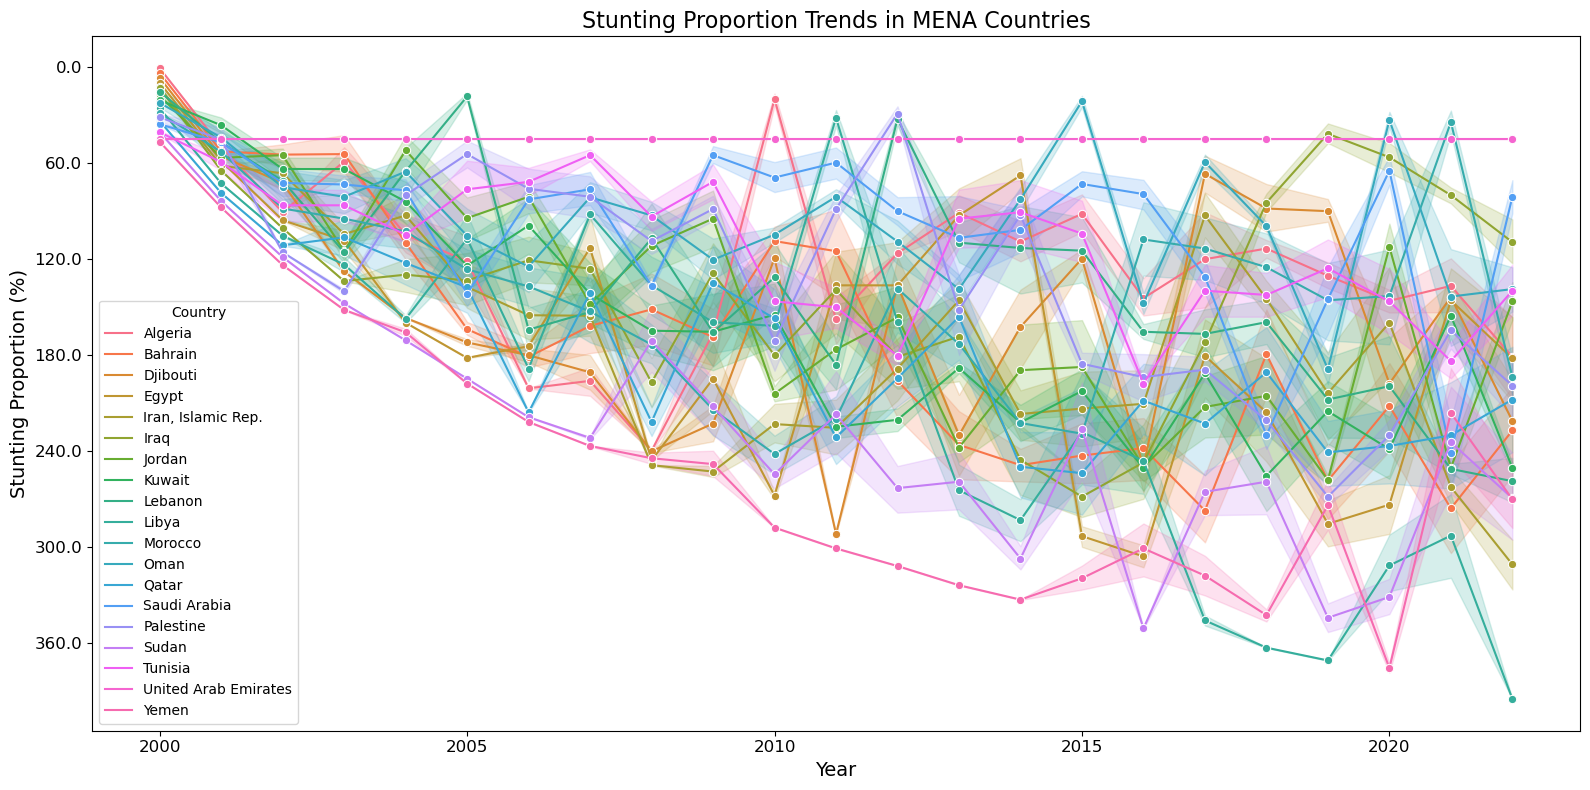

In [38]:
plt.figure(figsize=(16, 8))
ax = sns.lineplot(data=merged_df, x="Year", y="Stunting Proportion", hue="Country", marker="o")
ax.set_title("Stunting Proportion Trends in MENA Countries", fontsize=16)
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Stunting Proportion (%)", fontsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.yaxis.set_major_locator(MaxNLocator(nbins=8))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tight_layout()
plt.show()
